# Competitive Network

Problem: Classifying flowers into 3 classes

For this problem we use a Competitive Learning clustering algorithm.

Competitive Network characteristics:
- Comprises an input layer and a competitive neuron layer
- Neurons should be equal to or more than the classes
- Unsupervised
- Neurons compete as to which one fits better to the input vector
- Winner neurons move towards the examples for which they won
- A winner is a neuron with the minimum distance from the according example / point
- Classification of an example to a specific class depends on the index of the winner neuron
- If the neurons are less than the classes, to which the examples are classified, the winner / representative can end up between 2 classes
- If neurons are more than the classes, to which the examples are classified, some will be winners / representatives of classes and some will not move towards any class, therefore representing no class

Training:
- Initialize the neurons to random values. It is best for neurons to be initialized within a given range which represents the minimum and maximum values of the point features, so as not only one neuron wins each time for all examples / points.
- For each point the winner neuron moves towards the point:
    - Winner neuron:
    \begin{equation}
    d_s = ||w^{(s)} - x^{(p)}|| = min(||w^{(k)} - x^{(p)}||)
    \end{equation}
    where k are the classes and p is the corresponding point
    - Training:
    \begin{equation}
    w^{(s)} = w^{(s)} + \beta(r) * (x^{(p)} - w^{(S)}
    \end{equation}
    where β(r) is the learning rate for epoch r
    - Change of learning rate - the learning rate starts from a large value and is reduced during training:
    \begin{equation}
    \beta(r+1) = \beta(r) * (1 * \frac{r}{Max\_Epochs})
    \end{equation}

------------------

Architecture:
- Neurons:
    - Number of neurons 4
    - Dimension of neurons 4 - as many as dataset features
- Learning rate 1
- Max epochs 400

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

For the competitive learning network we created our own implementation.
The class of the network consists of:
- A constructor that accepts the dimensions of the network to initialize the neuron weights, as well as max and min values, to ensure that all neurons will be initialized near the values of the data.<br>
This ensures that one or few neurons will not always win, and that every neuron will take part in the training process.<br>
The constructor also accepts a learning rate and maximum number of epochs.
- A train method which updates the weight of the winner neuron each time
- A predict method of the nearest / winner neurons
- A closest_idx method for finding the closest winner neuron, used by the previous two methods

In [2]:
class Competitive(object):
    def __init__(self, input_dim, num_neurons, lr, max_epochs, low, high):
        self.input_dim = input_dim
        self.num_neurons = num_neurons
        self.W = np.random.uniform(low, high, (num_neurons, input_dim))
        self.lr = lr
        self.max_epochs = max_epochs
        self.iter = 0

    def train(self, X, num_epochs):
        for epoch in range(num_epochs):
            self.iter += 1
            for x in X:
                min_idx = self.closest_idx(x)
                self.W[min_idx] += self.lr * (x - self.W[min_idx])
            self.lr *= 1 - self.iter / self.max_epochs

    def predict(self, X):
        return self.closest_idx(X)

    def closest_idx(self, x):
        return np.array([np.linalg.norm(x - self.W[i], axis=-1) for i in range(self.num_neurons)]).argmin(0)

Just as before, we use a plot_training method, which displays two plots. The usual static plot with the points and the true classes, and a dynamic one for plotting the progression and movement of neurons, as well as the classification of points by the model.

In [3]:
def plot_training(model, X_train, t_train):
    fig, axes = plt.subplots(2, 1)
    for ax in axes:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    n_iter = 100
    
    # Plot 1 - static
    sns.scatterplot(x=X_train[:,0], y=X_train[:,2], 
                    hue=t_train, style=t_train,
                    ax=axes[0])
    
    for i in range(n_iter):
        axes[1].clear()

        axes[0].set_title('Epoch ' + str(i + 1) + ' out of ' + str(n_iter))
        model.train(X_train, 1)

        train_pred = model.predict(X_train)
        
        # Plot 2
        sns.scatterplot(x=X_train[:,0], y=X_train[:,2],
                        hue=train_pred, style=train_pred, ax=axes[1])
        neurons = np.array(model.W)
        sns.scatterplot(x=neurons[:,0], y=neurons[:,2], palette='PiYG',
                        hue=range(model.num_neurons), style=range(model.num_neurons),
                        size=range(model.num_neurons), sizes=(50, 300), ax=axes[1])
        
        fig.canvas.draw()
        plt.pause(0.1)

Similarly to the Boston housing dataset, the iris dataset is also provided by scikit-learn.

We load the dataset.

In [4]:
data = load_iris()

We look at its description

In [5]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

And study its features and targets

In [6]:
data.feature_names, data.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

We split into training and test set

In [7]:
X_train, X_test, t_train, t_test = train_test_split(data.data, data.target, stratify=data.target)
X_train = X_train[t_train.argsort()]
t_train.sort()
X_test = X_test[t_test.argsort()]
t_test.sort()

In [8]:
X_train.shape[1]

4

We extract the minimum and maximum values of the features

In [9]:
data_low, data_high = data.data.min(0), data.data.max(0)

Which we use to initialize the model

In [10]:
model = Competitive(X_train.shape[1], 4, 1, 400, data_low, data_high)

We train our model using plot_training

<IPython.core.display.Javascript object>


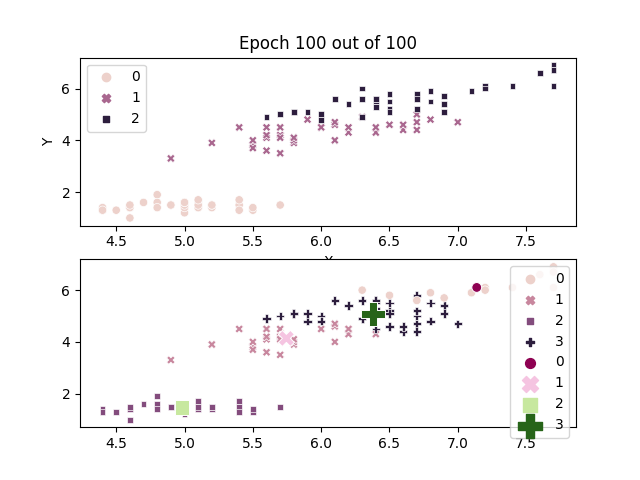

In [11]:
%matplotlib notebook
plot_training(model, X_train, t_train)

And finally, we display in a plot the neurons along with the predictions of the test set points.

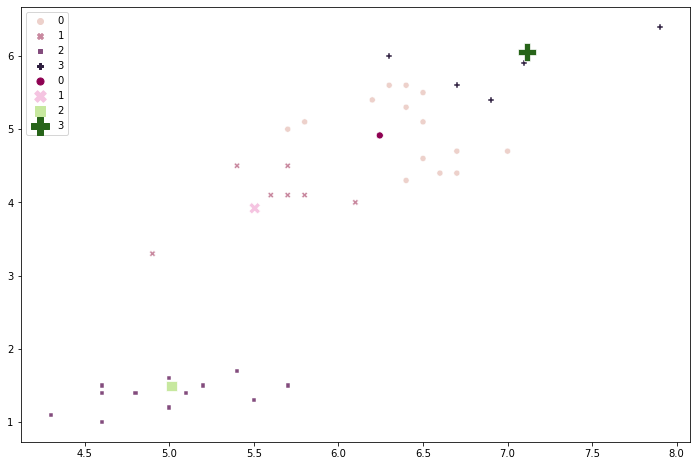

In [13]:
%matplotlib inline
test_pred = model.predict(X_test)

plt.figure(figsize=(12,8))
sns.scatterplot(x=X_test[:,0], y=X_test[:,2],
                hue=test_pred, style=test_pred)
neurons = np.array(model.W)
sns.scatterplot(x=neurons[:,0], y=neurons[:,2], palette='PiYG',
                hue=range(model.num_neurons), style=range(model.num_neurons),
                size=range(model.num_neurons), sizes=(50, 300))
plt.show()